# Deep Learning Challenge
# Emotionserkennung mit CNN
## Michelle Rohrer


### Pakete laden

In [16]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import os
import json
import wandb
import pickle
from dotenv import load_dotenv

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_class_distribution, 
    plot_sample_images,
    plot_cross_validation_results,
    plot_confusion_matrix
)
from src.model import BaselineCNN
from src.test_train import (
    overfitting_test_batch
)
from src.evaluation import (
    evaluate_model
)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden und vorbereiten
Die Daten wurden von kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

Infos zu den Daten:

Die Daten bestehen aus 48x48 Pixel grossen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

Die Aufgabe besteht darin, jedes Gesicht anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zuzuordnen (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Der Trainingssatz besteht aus 28.709 Beispielen und der öffentliche Testsatz aus 3.589 Beispielen.

In [17]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

In [18]:
img_size = 48
batch_size = 64

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


#### Aufteilung in Trainings- und Validierungsdatensatz

Für die Entwicklung und Evaluation der Modelle wurde der Trainingsdatensatz in zwei separate Teilmengen aufgeteilt. Einen Trainingsdatensatz und einen Validierungsdatensatz im Verhältnis 80/20.

##### Begründung für die Aufteilung

Der Validierungsdatensatz ermöglicht es, die Leistung des Modells während des Trainingsprozesses auf bisher ungesehenen Daten zu evaluieren. Ohne diese Aufteilung bestünde eine höhere Gefahr des Overfittings, das Modell würde also die Trainingsdaten auswendig lernen, anstatt generalisierbare Muster zu erkennen. Der Validierungsdatensatz fungiert somit als unabhängige Kontrollinstanz, die frühzeitig Anzeichen von Overfitting aufdecken kann.

##### Die Wahl des 80/20-Verhältnisses

Das gewählte Verhältnis von 80% Trainings- und 20% Validierungsdaten hat sich in der Praxis bewährt und stellt einen ausgewogenen Kompromiss dar. Mit 80% der Daten für das Training steht dem Modell eine ausreichend grosse Datenmenge zur Verfügung, um robuste Muster zu lernen. Gleichzeitig sind 20% für die Validierung gross genug, um statistisch aussagekräftige Metriken zu liefern und die Generalisierungsfähigkeit zuverlässig zu bewerten.

### Expolorative Datenanalyse

#### Klassenverteilung

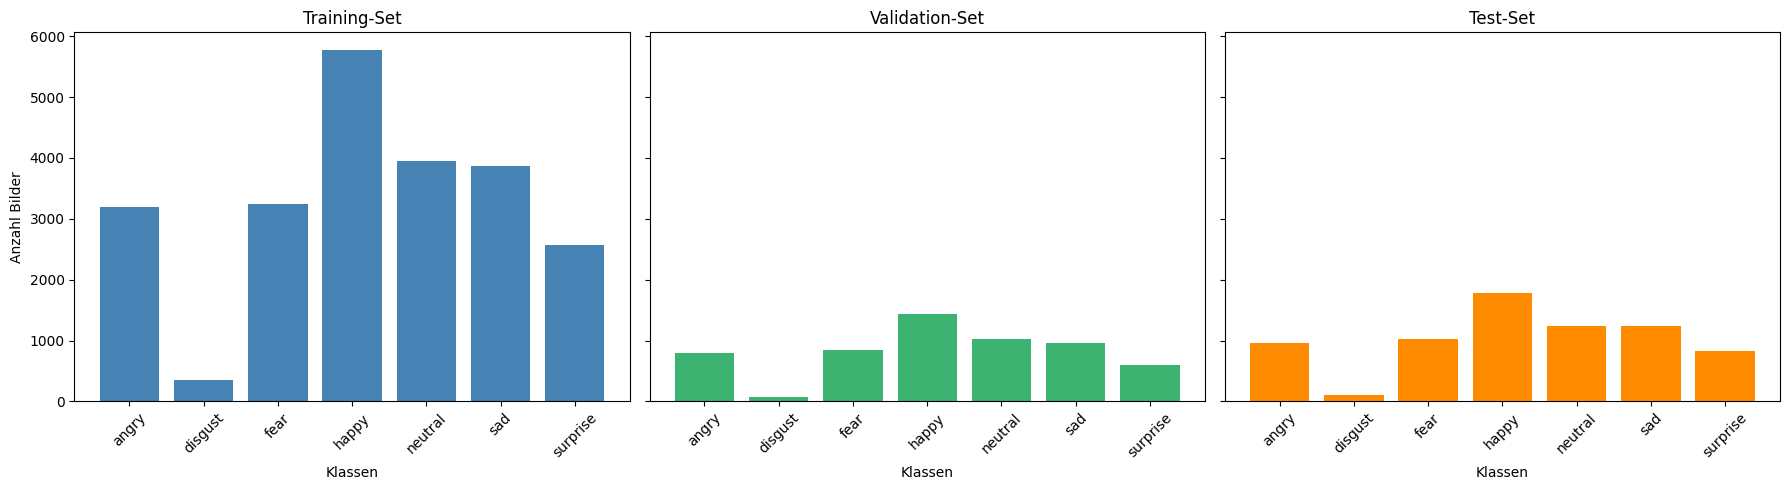

In [19]:
plot_class_distribution(train_dataset, val_dataset, test_dataset)

***Auswertung:*** Die Analyse zeigt eine unbalancierte Verteilung der Klassen im Datensatz. Während *"happy"* mit Abstand am häufigsten vertreten ist, weist die Klasse *"disgust"* deutlich weniger Beispiele auf als alle anderen Kategorien. Diese Klassenungleichgewichte können die Modellperformance beeinflussen und müssen bei der Modellevaluation berücksichtigt werden.

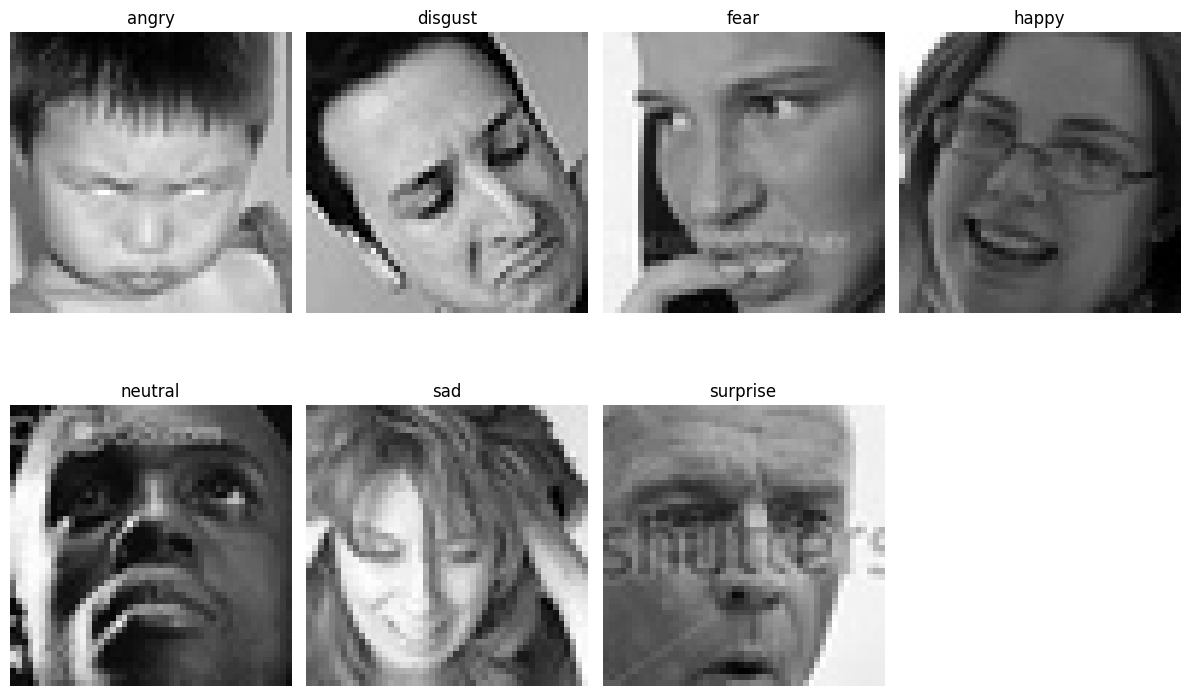

In [20]:
fig = plot_sample_images(full_train_dataset)
plt.show()

***Auswertung:*** Bei der visuellen Analyse der Beispieldaten fällt auf, dass die Klassifikation der Gesichtsausdrücke subjektiv und nicht eindeutig ist. Verschiedene Personen in meinem Umfeld interpretierten die gezeigten Bilder unterschiedlich. Beispielsweise wurde das Bild der Kategorie "disgust" (Ekel) als selbstverliebt oder kritisch wahrgenommen. Diese Beobachtung unterstreicht die Herausforderung der Emotionserkennung, da Gesichtsausdrücke oft mehrdeutig sind und kulturell sowie individuell unterschiedlich interpretiert werden können.

### Überblick der Metriken

Für die Evaluation werden verschiedene Metriken eingesetzt, um die Modellperformance umfassend zu bewerten:

#### 1. **Konfusionsmatrix-basierte Metriken**

**Accuracy (Genauigkeit):**
Die Accuracy misst den Anteil der korrekt klassifizierten Samples an der Gesamtanzahl. Sie gibt einen ersten Überblick über die Gesamtleistung des Modells, ist jedoch bei unbalancierten Datensätzen wie dem FER-2013-Datensatz mit Vorsicht zu interpretieren.

**Precision (Präzision):**
Die Precision für jede Klasse misst, wie viele der als Klasse X vorhergesagten Samples tatsächlich zur Klasse X gehören. Diese Metrik ist besonders wichtig, um False Positives zu identifizieren.

**Recall (Sensitivität):**
Der Recall misst, wie viele Samples einer bestimmten Klasse korrekt erkannt wurden. Diese Metrik ist entscheidend, um zu verstehen, wie gut das Modell seltene Klassen (wie "disgust") erkennt.

#### 2. **F1-Score**

Der F1-Score kombiniert Precision und Recall zu einer einzigen Metrik und stellt das harmonische Mittel dar. Er ist besonders wertvoll bei unbalancierten Datensätzen, da er sowohl False Positives als auch False Negatives berücksichtigt.

#### 3. **Top-K Accuracy**

Die Top-K Accuracy misst, ob die korrekte Klasse unter den K wahrscheinlichsten Vorhersagen liegt. Dies ist besonders relevant für Emotionserkennung, da ähnliche Emotionen (z.B. "fear" und "surprise") oft verwechselt werden können.

#### 4. **Cross-Validation**

Die Verwendung von Cross-Validation ermöglicht eine robustere Evaluation, indem das Modell auf verschiedenen Datenaufteilungen trainiert und getestet wird. Dies reduziert die Varianz der Ergebnisse und gibt eine zuverlässigere Einschätzung der Generalisierungsfähigkeit.

Diese umfassende Metrikenauswahl ermöglicht es, sowohl die Gesamtleistung als auch die spezifischen Stärken und Schwächen des Modells in verschiedenen Emotionskategorien zu bewerten.

### Baseline

#### Architektur des Baseline-CNN

Als Basismodell wird ein einfaches Convolutional Neural Network verwendet. Die Architektur besteht aus drei aufeinanderfolgenden Convolutional Blocks, gefolgt von zwei Fully Connected Layers für die Klassifikation.

**Feature Extraction:**
Der Feature-Extraction-Teil umfasst drei Convolutional Blocks mit steigender Filterzahl (16, 32, 64 Filter). Jeder Block besteht aus einer Convolutional Layer mit 3x3 Kernel-Größe und ReLU-Aktivierungsfunktion, gefolgt von einer Max-Pooling-Layer mit 2x2 Kernel.

**Klassifikation:**
Die Output-Layer verwendet keine explizite Aktivierungsfunktion, da der CrossEntropyLoss in PyTorch implizit Softmax anwendet.

**Training-Konfiguration:**
Für das Basismodell wird der Stochastic Gradient Descent (SGD) ohne Momentum als Optimizer verwendet. Die Learning Rate wird auf 0.01 gesetzt.

In [21]:
# Modell erstellen
num_classes = len(full_train_dataset.class_to_idx)
test_model = BaselineCNN(img_size=img_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(device)

# Summary anzeigen
summary(test_model, input_size=(1, img_size, img_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
         MaxPool2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Linear-7                   [-1, 64]         147,520
            Linear-8                    [-1, 7]             455
Total params: 171,271
Trainable params: 171,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.62
Params size (MB): 0.65
Estimated Total Size (MB): 1.28
----------------------------------------------------------------


#### Overfitting Test

**Zielsetzung und Begründung:**
Vor dem Training auf dem vollständigen Datensatz ist es essentiell zu verifizieren, dass das Modell überhaupt in der Lage ist zu lernen. Der Overfitting-Test ist eine Absicherung, bei dem das Modell absichtlich auf einer minimalen Datenmenge trainiert wird, um zu überprüfen, ob die Modellarchitektur, die Forward- und Backward-Passes sowie die Gradientenberechnung korrekt implementiert sind.

In [22]:
# Model testen
loss, accuracy = overfitting_test_batch(test_model, device, train_loader, num_epochs=350)

Epoch   1 | Loss: 1.946217 | Accuracy: 0.1719 (11/64 correct)
Epoch  20 | Loss: 1.721980 | Accuracy: 0.2969 (19/64 correct)
Epoch  40 | Loss: 1.709658 | Accuracy: 0.2969 (19/64 correct)
Epoch  60 | Loss: 1.849916 | Accuracy: 0.2969 (19/64 correct)
Epoch  80 | Loss: 1.761407 | Accuracy: 0.1875 (12/64 correct)
Epoch 100 | Loss: 1.639161 | Accuracy: 0.3906 (25/64 correct)
Epoch 120 | Loss: 1.550279 | Accuracy: 0.4688 (30/64 correct)
Epoch 140 | Loss: 1.532327 | Accuracy: 0.4531 (29/64 correct)
Epoch 160 | Loss: 1.347300 | Accuracy: 0.5156 (33/64 correct)
Epoch 180 | Loss: 1.364877 | Accuracy: 0.5156 (33/64 correct)
Epoch 200 | Loss: 1.080002 | Accuracy: 0.5938 (38/64 correct)
Epoch 220 | Loss: 1.089163 | Accuracy: 0.6094 (39/64 correct)
Epoch 240 | Loss: 1.984832 | Accuracy: 0.3125 (20/64 correct)
Epoch 260 | Loss: 0.301236 | Accuracy: 0.9062 (58/64 correct)
Epoch 280 | Loss: 0.052048 | Accuracy: 1.0000 (64/64 correct)
Epoch 300 | Loss: 0.014980 | Accuracy: 1.0000 (64/64 correct)
Epoch 32

***Auswertung:*** Das Modell erreicht nach etwa 250 Epochen eine Accuracy von 100%, was bestätigt, dass die Modellarchitektur und die Implementierung grundsätzlich funktionsfähig sind. Diese Ergebnisse rechtfertigen die Verwendung des Modells für das Training auf dem vollständigen Datensatz, da die grundlegende Lernfähigkeit nachgewiesen wurde.

#### Trainierte Modelle laden

Die Modellentwicklung und das Training wurden im Notebook `training.ipynb` implementiert.

In [23]:
# Laden der trainierten Modelle
# Prüfen ob Modelle existieren
models_dir = "models"
if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
    print(f"Gefundene Modell-Dateien: {model_files}")
else:
    print("Models-Verzeichnis nicht gefunden.")


Gefundene Modell-Dateien: ['baseline_model.pth']


In [24]:
# Basismodell laden
baseline_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)
baseline_model.load_state_dict(torch.load(os.path.join(models_dir, "baseline_model.pth"), map_location=device))
baseline_model.eval()  # Setze Modell in Evaluation-Modus
print("Basismodell erfolgreich geladen")


Basismodell erfolgreich geladen


#### Evaluation der trainierten Modelle

Hier werden die trainierten Modelle auf dem Test-datensatz evaluiert und die Performance analysiert.

In [25]:
# Device Setup für Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())

Verwende Device: cpu


=== Training des Basismodells ===


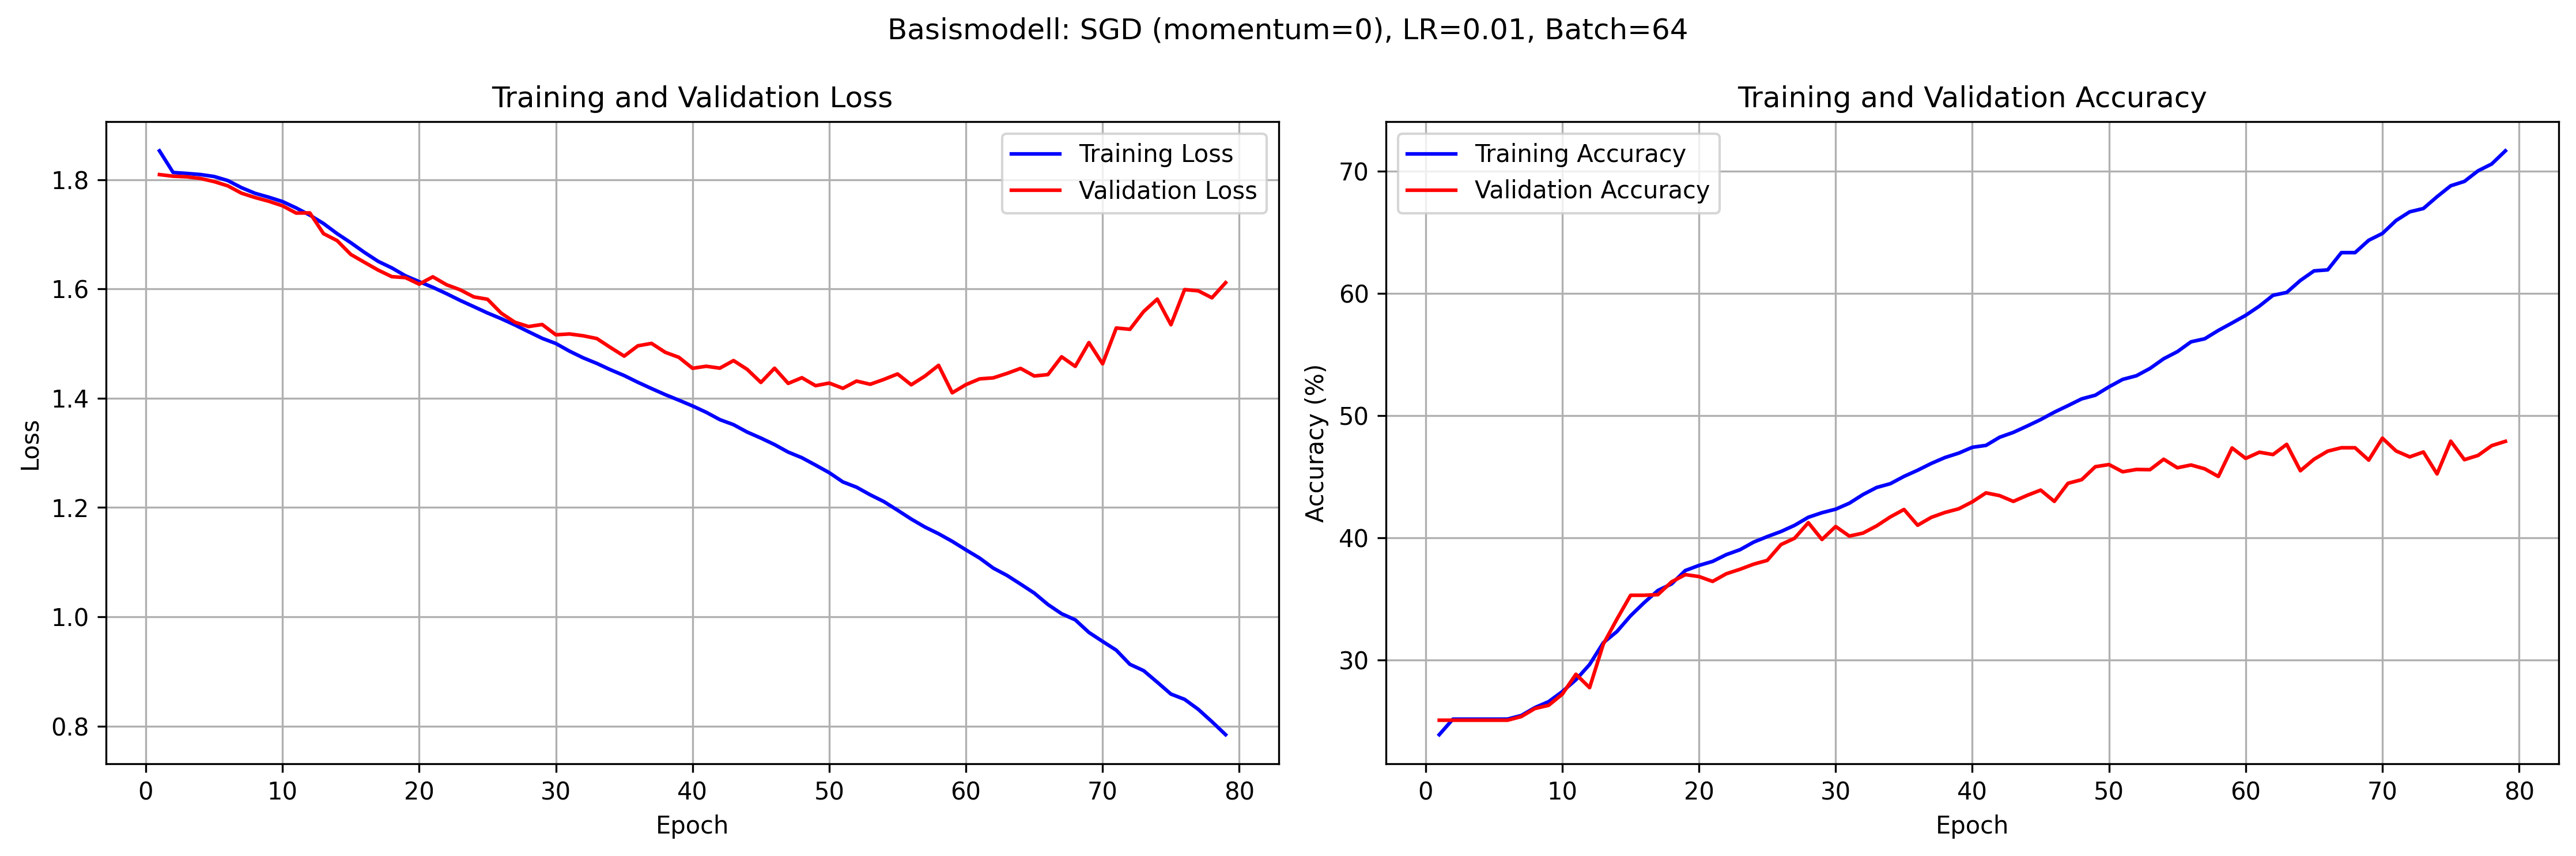

In [26]:
# Lernkurven des Basismodells anzeigen
# Prüfen ob das Plot-Bild existiert
print("=== Training des Basismodells ===")
plot_path = "plots/baseline_training_curves.png"
if os.path.exists(plot_path):
    display(Image(filename=plot_path))
else:
    print(f"Plot-Bild nicht gefunden unter: {plot_path}")

***Auswertung:*** Die Lernkurven des Basismodells zeigen deutliche Anzeichen von Overfitting. Nach etwa 80 von 200 Epochen wurde das Training frühzeitig beendet, da sich 20 Epochen lang keine Verbesserung des Validation Loss zeigte.

**Training vs. Validation Loss:**
- Der Training Loss sinkt kontinuierlich von ~1.8 auf unter 0.8 über 80 Epochen
- Der Validation Loss steigt ab Epoche 25 deutlich an und erreicht ~1.6
- Die Divergenz zwischen Training und Validation Loss ist ein klassisches Overfitting-Signal

**Training vs. Validation Accuracy:**
- Die Training Accuracy steigt stetig von 25% auf über 70%
- Die Validation Accuracy stagniert ab Epoche 20-25 bei ~40-48%
- Der große Abstand zwischen Training (70%+) und Validation (~45%) bestätigt Overfitting

Das Modell lernt die Trainingsdaten sehr gut auswendig, kann aber nicht auf neue Daten generalisieren. Dies ist zu erwarten, da es sich um ein einfaches Basismodell handelt. Das Overfitting zeigt, dass das Modell die Trainingsdaten auswendig lernt, anstatt generalisierbare Muster zu erkennen.

=== Evaluation des Basismodells ===
Test Accuracy: 0.4845
Precision (weighted): 0.4884
Recall (weighted): 0.4845
F1-Score (weighted): 0.4840
Precision (macro): 0.4925
Recall (macro): 0.4389
F1-Score (macro): 0.4542
Top-2 Accuracy: 0.6723


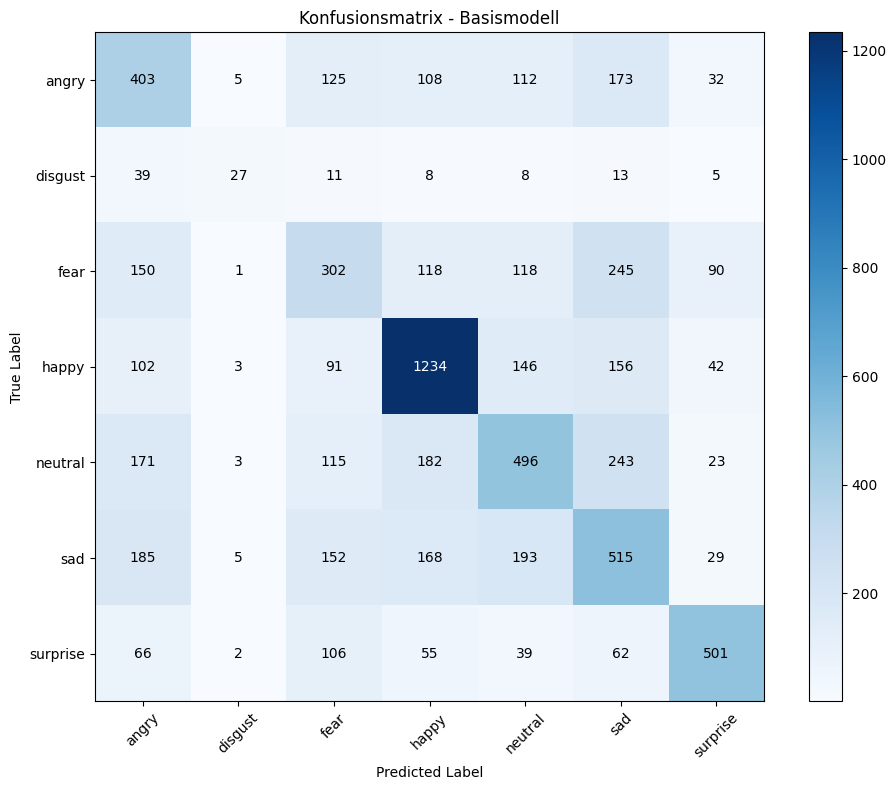

In [27]:
# Detaillierte Evaluation des Basismodells
print("=== Evaluation des Basismodells ===")

# Test-Set Evaluation
test_results = evaluate_model(baseline_model, device, test_loader, class_names, 
                            use_wandb=False, run_name="baseline_evaluation")

print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision (weighted): {test_results['precision_weighted']:.4f}")
print(f"Recall (weighted): {test_results['recall_weighted']:.4f}")
print(f"F1-Score (weighted): {test_results['f1_weighted']:.4f}")
print(f"Precision (macro): {test_results['precision_macro']:.4f}")
print(f"Recall (macro): {test_results['recall_macro']:.4f}")
print(f"F1-Score (macro): {test_results['f1_macro']:.4f}")
print(f"Top-2 Accuracy: {test_results['top2_accuracy']:.4f}")

# Konfusionsmatrix plotten
fig = plot_confusion_matrix(
    confusion_matrix=test_results['confusion_matrix'],
    class_names=class_names,
    title='Konfusionsmatrix - Basismodell'
)


***Auswertung:*** Die Evaluationsergebnisse des Basismodells zeigen einige stärken und schwächen des Modells für die Emotionserkennung:

**Allgemeine Performance:**
- Test Accuracy: 48.45%: Das Modell klassifiziert nur etwa die Hälfte der Testbilder korrekt
- F1-Score (macro): 45.42%: Niedrige durchschnittliche Performance über alle Klassen
- Top-2 Accuracy: 67.23% Deutlich höher als Top-1, zeigt dass das Modell oft "nahe dran" ist

**Problematische Aspekte:**
- Niedrige Gesamtleistung bestätigt das in den Lernkurven beobachtete Overfitting
- Ungleichgewichtige Klassifikation zwischen verschiedenen Emotionen
- Schwierigkeiten bei der Unterscheidung ähnlicher Emotionen (z.B. angry vs. fear vs. sad)

**Positive Aspekte:**
- **Top-2 Accuracy deutlich höher: Das Modell hat oft die richtige Antwort unter den Top-2 Vorhersagen
- Grundlegende Lernfähigkeit vorhanden, aber Generalisierung unzureichend

Das Basismodell zeigt die erwarteten Schwächen eines einfachen Modells ohne Regularisierung. Die niedrige Accuracy und die Verwechslungen zwischen ähnlichen Emotionen unterstreichen die Notwendigkeit für verbesserte Architekturen und Regularisierungstechniken. Jedoch zeigen sich auch bereits positive Ansätze des Modells, insbesondere die deutlich höhere Top-2 Accuracy und die grundlegende Lernfähigkeit, die als solide Grundlage für weitere Verbesserungen dienen. Positive Emotionen (Happy, Surprise) können deutlich besser erkannt werden als negative Emotionen (Disgust, Fear, Sad, Angry). Dies könnte auf die Datenverteilung oder die visuellen Eigenschaften dieser Emotionen zurückzuführen sein.

#### Hyperparameter-Tuning Ergebnisse

Hier werden die Ergebnisse des Hyperparameter-Tunings gezeigt.

== Ergebnisse des Hyperparameter-Tunings ==


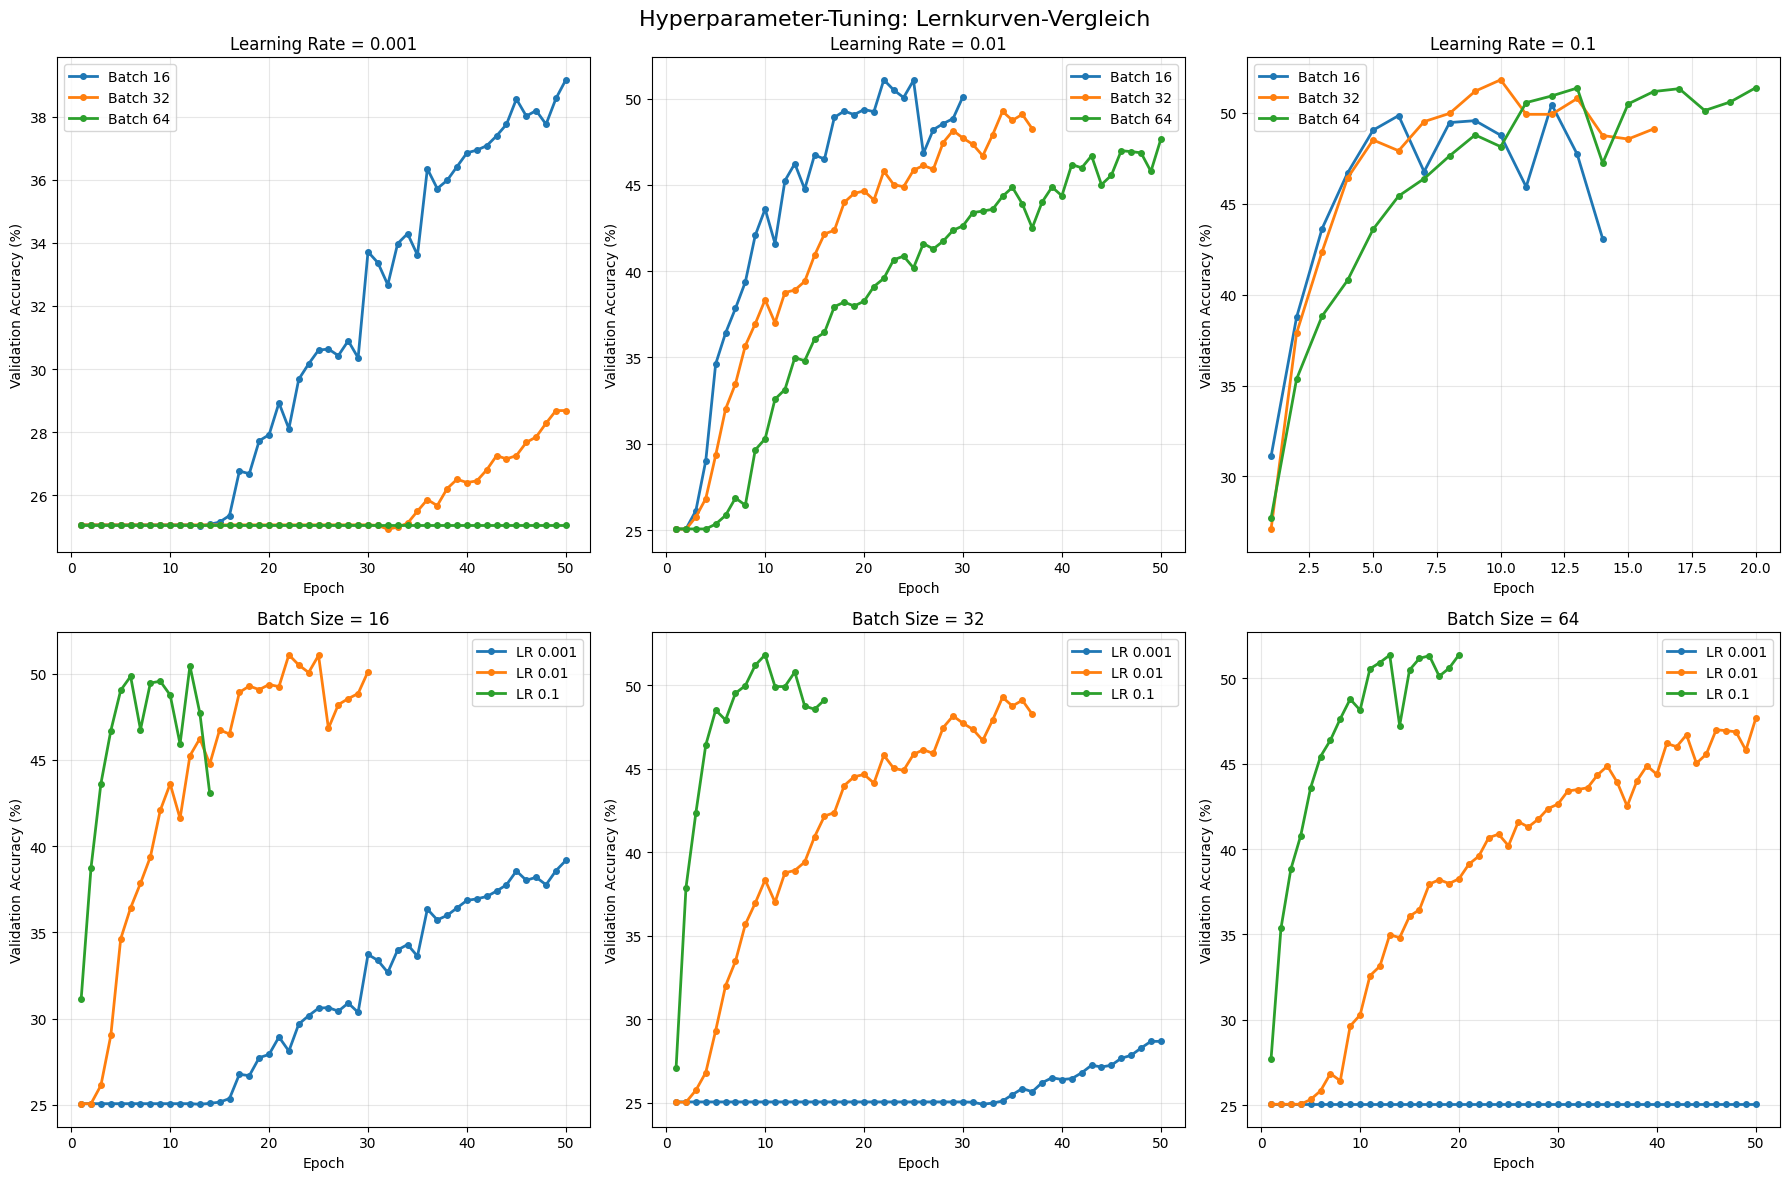

Beste Hyperparameter: LR=0.1, Batch=64


In [28]:
# Ergebnisse des Hyerparameter-tunings
# Prüfen ob das Plot-Bild existiert
print("== Ergebnisse des Hyperparameter-Tunings ==")
plot_path = "plots/hyperparameter_comparison.png"
if os.path.exists(plot_path):
    display(Image(filename=plot_path))
else:
    print(f"Plot-Bild nicht gefunden unter: {plot_path}")

results_dir = "results"
cv_results_file = os.path.join(results_dir, "cross_validation_results.json")
with open(cv_results_file, 'r') as f:
    cv_results = json.load(f)
print(f"Beste Hyperparameter: LR={cv_results['best_hyperparameters']['learning_rate']}, Batch={cv_results['best_hyperparameters']['batch_size']}")

***Auswertung:*** Das Hyperparameter-Tuning zeigt deutliche Unterschiede in der Performance verschiedener Konfigurationen:

**Lernrate 0.001:**
- Extrem langsames Lernen oder gar kein Fortschritt
- Besonders problematisch bei größeren Batch-Größen (32, 64)
- Nur bei Batch 16 minimaler Fortschritt (39% nach 50 Epochen)

**Lernrate 0.01:**
- Gute Balance zwischen Lernfortschritt und Stabilität
- Batch 16 & 32 erreichen über 48% Validierungsgenauigkeit
- Stabile Konvergenz ohne starke Oszillationen

**Lernrate 0.1:**
- Schnellste Konvergenz (erreicht 50%+ in 5-15 Epochen)
- Hohe Volatilität mit starken Oszillationen
- Einzige funktionierende Option für Batch-Größe 64
- Risiko der Instabilität trotz hoher Spitzenwerte

**Batch-Größe Einfluss:**
- Batch 16 & 32 funktionieren am besten mit allen Lernraten
- Batch 64 benötigt höhere Lernraten (0.1) für akzeptable Ergebnisse
- Kleinere Batches ermöglichen stabileres Lernen

**Theoretische Erwartungen:**
Nach der Theorie war zu erwarten, dass größere Batch-Größen präzisere Gradientenschätzungen liefern und daher höhere Lernraten tolerieren können, ohne zu stark zu oszillieren. Gleichzeitig sollten kleinere Batches (16, 32) mit moderaten Lernraten (0.01) eine gute Balance zwischen Explorationsfähigkeit durch stochastisches Rauschen und stabiler Konvergenz bieten. Die extrem niedrige Lernrate (0.001) war erwartungsgemäß zu konservativ für die begrenzte Epochenanzahl.

Die Cross-Validation Ergebnisse zeigen, dass **LR=0.1 mit Batch=64** die beste Konfiguration ist. Jedoch ist diese Kombination mit Vorsicht zu betrachten. Größere Batch-Größen liefern zwar stabilere Gradientenschätzungen und reduzieren das Rauschen im Training, jedoch kann eine zu hohe Lernrate (0.1) zu Overshooting führen, bei dem das Modell über das Optimum hinausschießt. Die beobachteten starken Oszillationen bestätigen dieses Risiko. Zudem besteht die Gefahr, dass das Modell in flachen lokalen Minima stecken bleibt oder die Generalisierungsfähigkeit durch zu aggressive Updates leidet.

**LR=0.01 mit Batch=16 oder 32** wäre vorzuziehen, wenn:
- Stabilität und Reproduzierbarkeit wichtiger sind als schnelle Konvergenz
- Das Training über mehr Epochen laufen kann
- Das Modell auf neue, ungesehene Daten besser generalisieren soll
- Die Trainingsverläufe weniger volatil sein sollen für bessere Interpretierbarkeit
- Ein Produktivsystem aufgebaut wird, bei dem robuste Performance kritisch ist

#### Cross-Validation Ergebnisse

Hier werden die Ergebnisse der Cross-Validation gezeigt.


=== Cross-Validation Ergebnisse ===
Training Accuracy: 85.2494 ± 2.4680
Validation Accuracy: 48.6711 ± 1.6248
Training Loss: 0.4100 ± 0.0679
Validation Loss: 2.2473 ± 0.1382


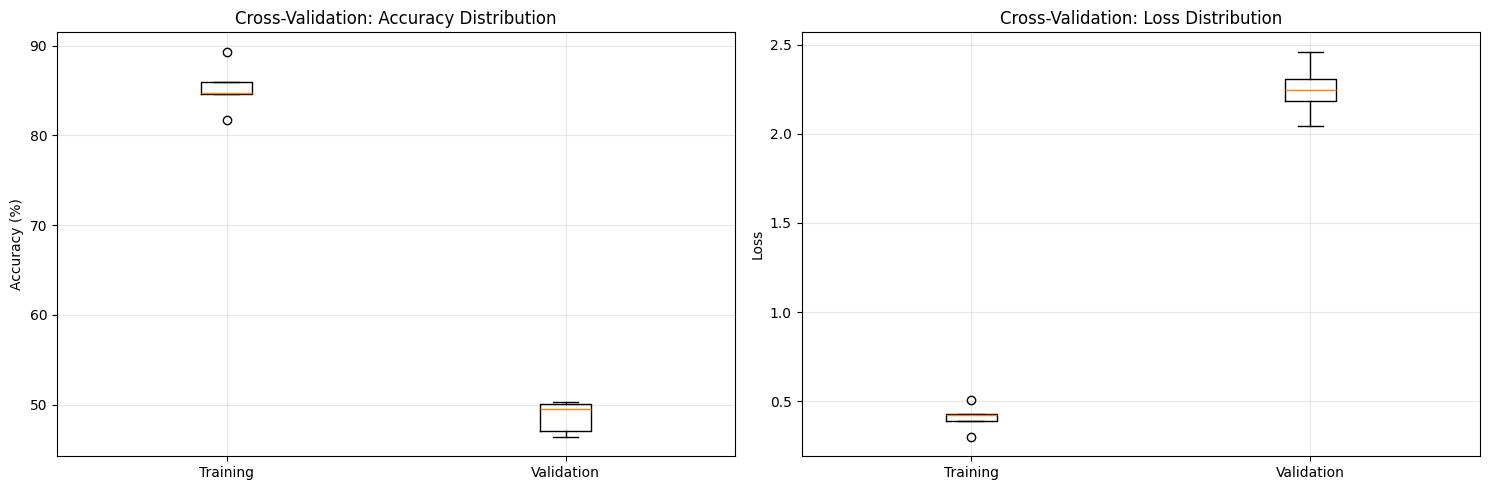

In [29]:
# Anzeigen der Cross-Validation Ergebnisse
print("=== Cross-Validation Ergebnisse ===")
print(f"Training Accuracy: {cv_results['cv_results']['train_accuracies']['mean']:.4f} ± {cv_results['cv_results']['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['cv_results']['val_accuracies']['mean']:.4f} ± {cv_results['cv_results']['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['cv_results']['train_losses']['mean']:.4f} ± {cv_results['cv_results']['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['cv_results']['val_losses']['mean']:.4f} ± {cv_results['cv_results']['val_losses']['std']:.4f}")

# Visualisierung der CV-Ergebnisse
fig = plot_cross_validation_results(
    cv_results=cv_results['cv_results']
)


***Auswertung:*** Die Cross-Validation wurde auf der besten Hyperparameter-Konfiguration (LR=0.1, Batch=64) durchgeführt und liefert wichtige statistische Erkenntnisse über die Modellperformance:

**Training vs. Validation Performance:**
- Training Accuracy: 85.25% ± 2.47%: Das Modell erreicht eine sehr hohe Accuracy auf den Trainingsdaten
- Validation Accuracy: 48.67% ± 1.62%: Deutlich niedrigere Performance auf ungesehenen Daten
- Performance Gap: 36.58%: Dieser große Unterschied bestätigt starkes Overfitting

**Loss-Analyse:**
- Training Loss: 0.41 ± 0.07: Sehr niedriger Loss auf Trainingsdaten
- Validation Loss: 2.25 ± 0.14: Deutlich höherer Loss auf Validierungsdaten
- Loss Ratio: ~5.5x: Der Validierungs-Loss ist mehr als 5-mal höher als der Training-Loss

**Statistische Robustheit:**
- Niedrige Standardabweichungen (1.62% für Validation Accuracy, 0.14 für Validation Loss) zeigen konsistente Performance über alle 5 Cross-Validation Folds
- Die engen Konfidenzintervalle bestätigen, dass die Ergebnisse statistisch zuverlässig sind
- Die geringe Varianz deutet darauf hin, dass die Hyperparameter-Konfiguration LR=0.1, Batch=64 robust über verschiedene Datenaufteilungen funktioniert

Obwohl die Cross-Validation bestätigt, dass LR=0.1 mit Batch=64 die beste verfügbare Konfiguration ist, zeigt das deutliche Overfitting (36.58% Performance-Gap), dass das Basismodell seine Grenzen erreicht hat. Die hohe Training Accuracy (85.25%) bei gleichzeitig niedriger Validation Accuracy (48.67%) unterstreicht die Notwendigkeit für erweiterte Regularisierungstechniken oder komplexere Modellarchitekturen, um die Generalisierungsfähigkeit zu verbessern.